In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color_pal = sns.color_palette() # import the olor paletter from seaborn

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Upload the dataset
df = pd.read_csv("PJME_hourly.csv")
df = df.set_index('Datetime')
df.index # as we can notice it's an "object" (dtype='object')
# We need/  must to convert it to datetime
df.index = pd.to_datetime(df.index) # dtype='datetime64[ns]' =>  It heps for good and clear visualization in xlabel 

# Sort the DataFrame by index (Datetime) to enable proper slicing
df = df.sort_index()
#len(df)

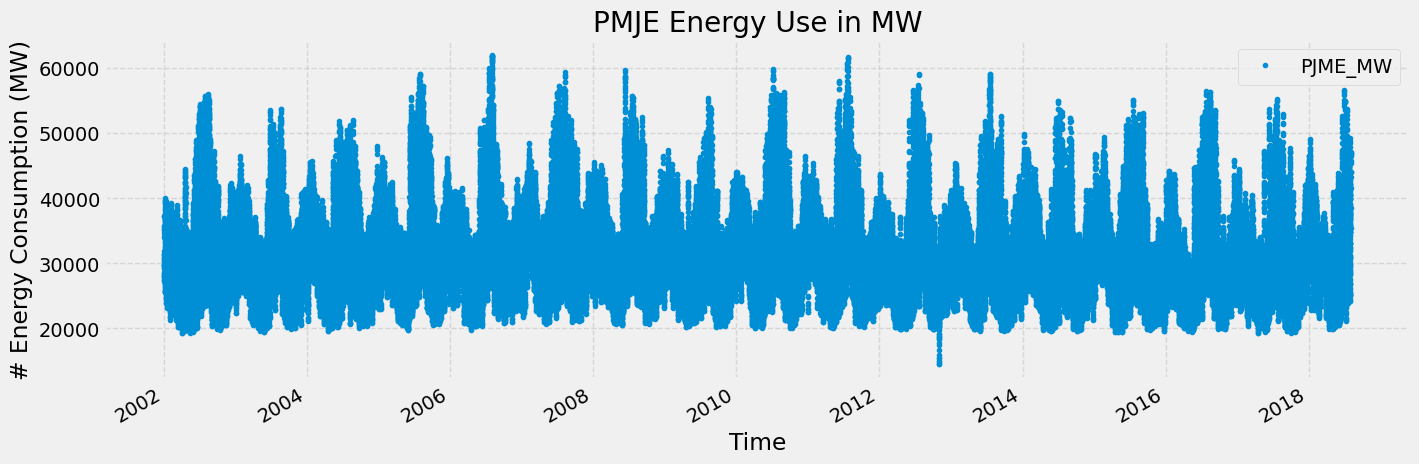

In [3]:
# Visualize the time serie
df.plot(
    style='.',                       # Use dots to represent data points in the plot
    figsize=(15, 5),                 # Set the size of the plot (width=15, height=5)
    color=color_pal[0],              # Choose a color for the plot (can be modified as needed)
    title='PMJE Energy Use in MW',   # Title of the plot
    xlabel='Time',                   # Label for the x-axis
    ylabel='# Energy Consumption (MW)' # Label for the y-axis
)
plt.grid(visible=True, linestyle='--', alpha=0.7) # Deactivate the grid use 'False
plt.show()

### Exploratory Data Analysis (EDA)

##### 1. Outlier Analysis \& Removal:

<Axes: ylabel='Frequency'>

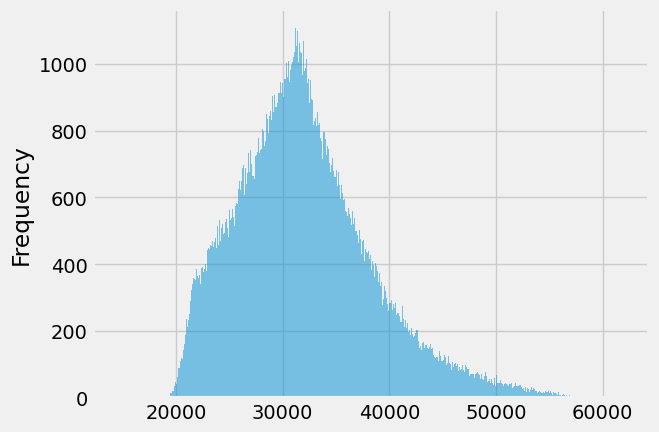

In [4]:
# a. Plot Histogram of this MW data
# Identify any bins with "unusually high frequencies or isolated bars", which may indicate outliers in the data
df['PJME_MW'].plot(kind='hist', alpha=0.5, bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

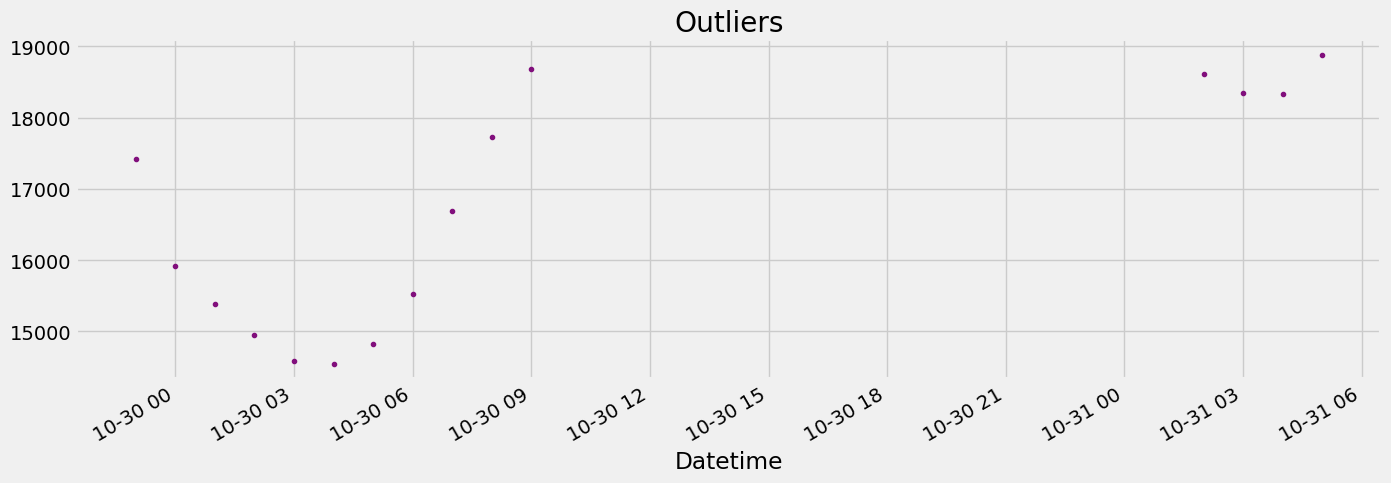

In [5]:
# b. Look wich outliers to remove
# Option 1: Visualy
#df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.') 

# As you can see there exist outliers in the area [2012 - 2014] where definitely are some outliers that don't look like they are ligitime.
# So trying to find a better threshold maybe less than 19_000
#df.query('PJME_MW < 19_000').plot(figsize=(15,5), style='.')
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',
                                             figsize=(15, 5), 
                                             color=color_pal[5], 
                                             title='Outliers')

# Now we can see that it's just these values that really dipped low that we would want to remove from our "training" and "validation'test" set

# Option 2: Computing a Statistical test (std)

In [6]:
# Creat a copy of the the filtered df
df = df.query('PJME_MW > 19_000').copy()

##### 2. Spliting the Time Series into "train set" and test set"
- Time Series Cross Validation: (best technique to split the T.S.)

In [7]:
from sklearn.model_selection import TimeSeriesSplit as TSS

# Split the Time Series (tss = time series split)
tss = TSS(n_splits=5,
          test_size=24*365*1,
          gap=24)
df = df.sort_index()

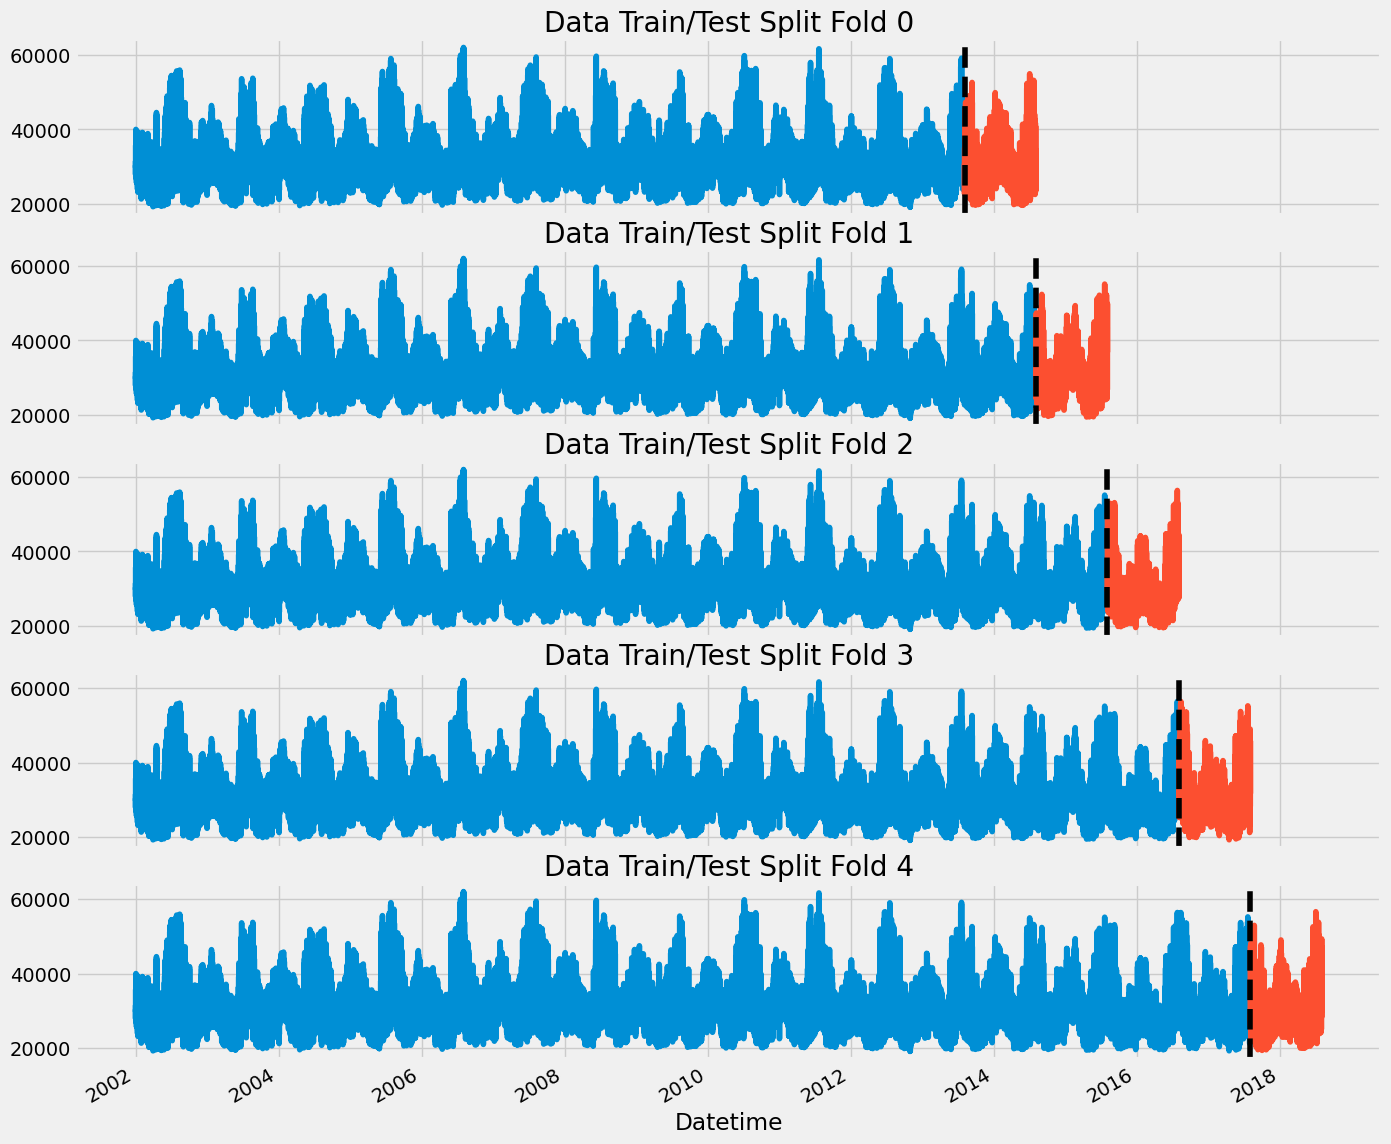

In [8]:
# Visualize the Splited T.S. (train set and test set)
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    # Plot "train set" and "test set"
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

##### 3. Forecasting Horizon Explained
-  Create time series features based on time series index.

In [9]:
# Create features
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

C:\Users\xps\AppData\Local\Temp\ipykernel_26248\3064588239.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette=color_pal)
C:\Users\xps\AppData\Local\Temp\ipykernel_26248\3064588239.py:5: UserWarning: 
The palette list has fewer values (6) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=df, x='hour', y='PJME_MW', palette=color_pal)


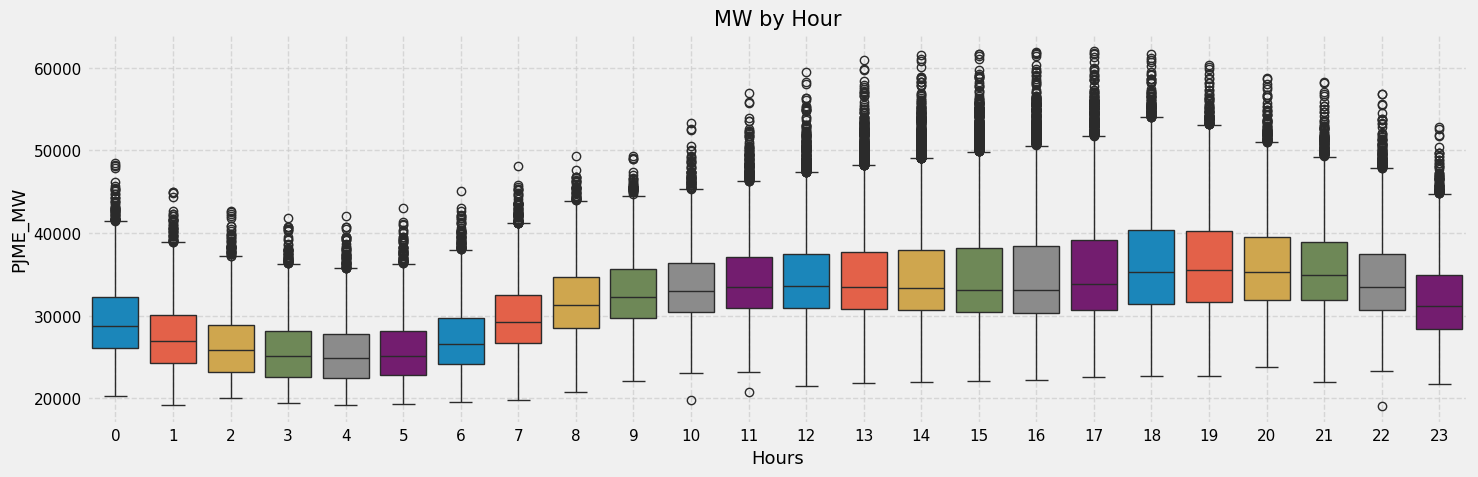

In [10]:
# Visualize the Feature /Target Relationship ("by Hour")
# It give us an idea about the distribution of the dataset

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette=color_pal)
# Set titles and labels
ax.set_title('MW by Hour', fontsize=15)
ax.set_xlabel('Hours', fontsize=13)
ax.set_ylabel('PJME_MW', fontsize=13)

# Customize grid and ticks for better readability
ax.grid(visible=True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='major', labelsize=11)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

##### 4. Lag Features
- What was the target (x) days in the past.

In [11]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364 days / 7 days = 52 (best selection!). But if u choose 365 we 'll get 52.14
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df 

df = add_lags(df)

##### 5. Train the Model

In [12]:
# Split the T.S.
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
# Define the Model
    reg = xgb.XGBRegressor(base_score=0.5, 
                           booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)

# Fit the Model
    reg.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
# Make the Prediction
    y_pred = reg.predict(X_test)
    preds.append(y_pred)

# Compute the Score
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.48134	validation_1-rmse:3900.86965
[400]	validation_0-rmse:3434.23853	validation_1-rmse:3762.33705
[441]	validation_0-rmse:3370.76149	validation_1-rmse:3764.48078
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3902.71304	validation_1-rmse:3933.73076
[400]	validation_0-rmse:3476.90515	validation_1-rmse:3590.55005
[500]	validation_0-rmse:3353.72424	validation_1-rmse:3516.39915
[600]	validation_0-rmse:3297.94766	validation_1-rmse:3481.94003
[700]	validation_0-rmse:3258.48267	validation_1-rmse:3461.37383
[800]	validation_0-rmse:3221.51553	validation_1-rmse:3436.49603
[900]	validation_0-rmse:3190.11480	validation_1-rmse:3428.88699
[999]	validation_0-rmse:3166.16314	validation_1-rmse:3420.31309
[0]	validation_0-rmse:32631.20370	validation_1-rmse:31073.29733


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12499.28425	validation_1-rmse:11136.72805
[200]	validation_0-rmse:5750.81453	validation_1-rmse:4813.21239
[300]	validation_0-rmse:3917.04200	validation_1-rmse:3553.40541
[400]	validation_0-rmse:3494.55924	validation_1-rmse:3495.25153
[410]	validation_0-rmse:3476.66883	validation_1-rmse:3502.18342
[0]	validation_0-rmse:32528.44438	validation_1-rmse:31475.39670


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.30026	validation_1-rmse:12019.98579
[200]	validation_0-rmse:5738.32648	validation_1-rmse:5794.44193
[300]	validation_0-rmse:3915.76448	validation_1-rmse:4385.51180
[400]	validation_0-rmse:3499.03653	validation_1-rmse:4172.17589
[500]	validation_0-rmse:3382.83569	validation_1-rmse:4116.88298
[600]	validation_0-rmse:3324.23232	validation_1-rmse:4104.48851
[700]	validation_0-rmse:3281.46398	validation_1-rmse:4088.10832
[800]	validation_0-rmse:3249.57813	validation_1-rmse:4081.68309
[900]	validation_0-rmse:3223.05405	validation_1-rmse:4071.80961
[999]	validation_0-rmse:3198.63557	validation_1-rmse:4048.63496
[0]	validation_0-rmse:32462.05557	validation_1-rmse:31463.90500


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.92077	validation_1-rmse:11962.25620
[200]	validation_0-rmse:5752.09311	validation_1-rmse:5610.63120
[300]	validation_0-rmse:3953.21146	validation_1-rmse:4149.60103
[400]	validation_0-rmse:3541.03825	validation_1-rmse:3998.83825
[440]	validation_0-rmse:3481.72497	validation_1-rmse:4001.67488


##### 6. Evaluating the Model's Performance

In [13]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3740.5258
Fold scores:[3760.8277187583353, 3420.313091887879, 3477.9504020604863, 4048.634962892725, 3994.9029963460744]


##### 7. Predicting the Future

1. Retraining on all data
2. To Predict the future we need an emtpy dataframe for future date ranges (create a new DataFrame).
3. Run those dates through our feature creation code + lag creation

In [14]:
# 1. Retraining on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, 
        y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32403.88991


C:\Users\xps\anaconda3\envs\MLDL\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.77634
[200]	validation_0-rmse:5753.18185
[300]	validation_0-rmse:3970.09750
[400]	validation_0-rmse:3569.04143
[499]	validation_0-rmse:3456.41787


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [15]:
# Create a new DataFrame for the forecast
# Check the maximum value in the Dataset to make the prediction for the future by using:
# Our training dataset goes up untill "2018-08-03" and make it as the first date in the new DataFrame

df.index.max()

# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h') # Forecating from '2018-08-03' to '2019-08-01'

future_df = pd.DataFrame(index=future) # new DataFrame
future_df['isFuture'] = True # Add a new column "isFuture" to save the future favlues 
df['isFuture'] = False # do the same for the df
df_and_future = pd.concat([df, future_df]) # Concatenate them to add the new dates to the time series

df_and_future = create_features(df_and_future) # Add a features to the new Time Series
df_and_future = add_lags(df_and_future) # Add a lags to it too

In [16]:
# Extract out just the future data (select the column where we will save the future data (isFuture)) by:
future_w_features = df_and_future.query('isFuture').copy()

In [17]:
# 2. Predict the Future
# Predict the future: future with features (future_w_features)
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

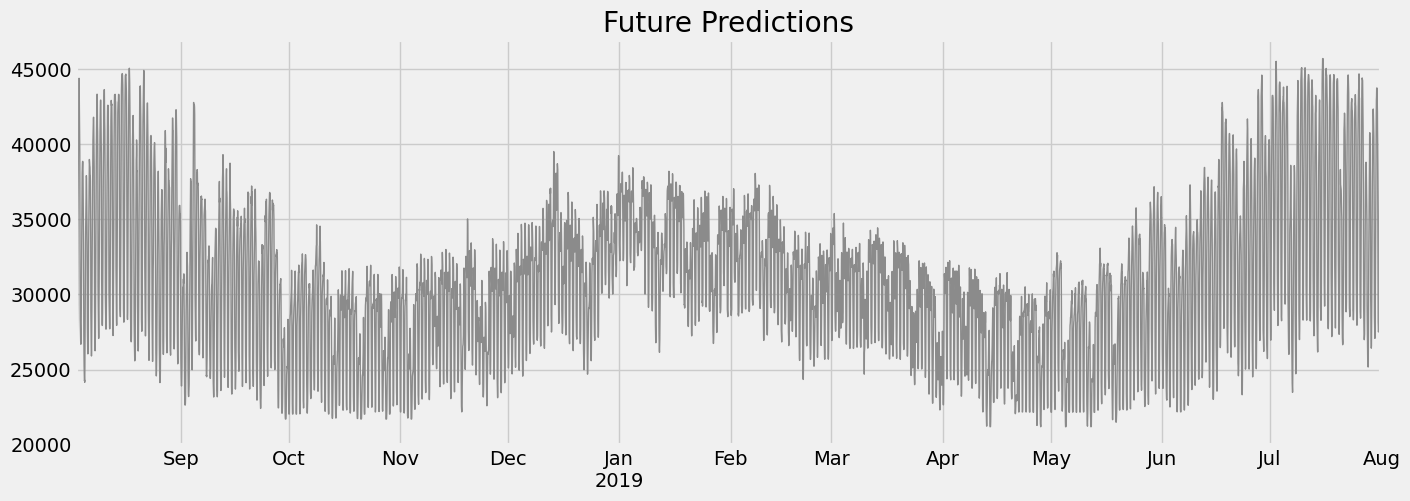

In [18]:
# Visualize the Prediction
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

##### 8. Saving the Model for later uses

<Axes: title={'center': 'Future Predictions'}>

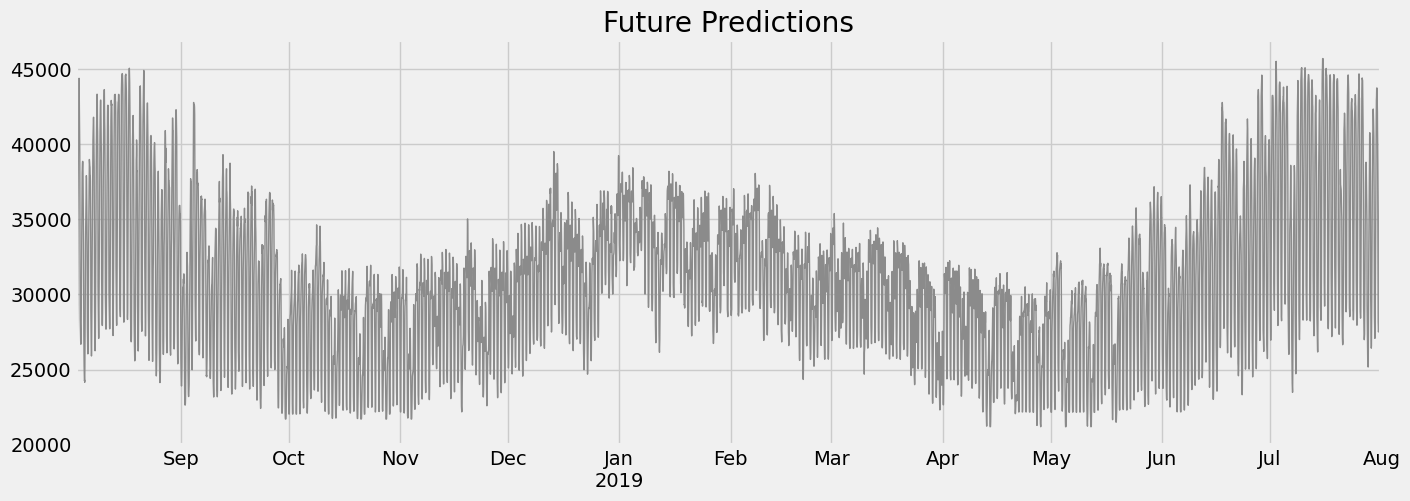

In [19]:
# Save model
reg.save_model('model.json')

reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')

### Forecasting for one day

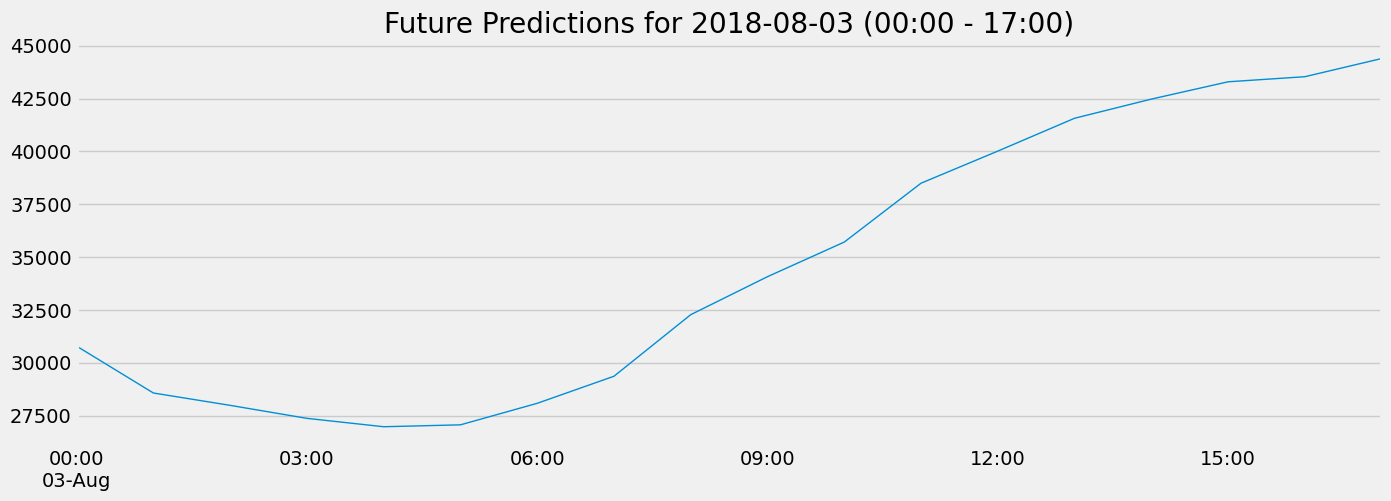

In [24]:
# Create future dataframe for the specific date and time range (2018-08-03 from 00:00 to 17:00)
future = pd.date_range('2018-08-03 00:00', '2018-08-03 17:00', freq='1h')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(index=future)  # new DataFrame
future_df['isFuture'] = True  # Add a new column "isFuture" to identify future data
df['isFuture'] = False  # Mark existing data as not future

# Concatenate existing and future data
df_and_future = pd.concat([df, future_df])  # Concatenate to add the new dates to the time series

# Add features and lags to the new combined DataFrame
df_and_future = create_features(df_and_future)  # Add features to the new Time Series
df_and_future = add_lags(df_and_future)  # Add lags for modeling

# Extract only the future data (those marked as "isFuture")
future_w_features = df_and_future.query('isFuture').copy()

# Predict the future data (for the specified date and time)
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

# Visualize the prediction
future_w_features['pred'].plot(figsize=(15, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions for 2018-08-03 (00:00 - 17:00)')
plt.show()